In [1]:
# !pip install sciann fteikpy pyDOE -q 

In [2]:
import time
import os

In [3]:
import numpy as np
import sciann as sn 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

---------------------- SCIANN 0.6.7.6 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.3 
Python Version: 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0] 



In [4]:
PATH_NAME = "EnDeepONet_Eikonal_Marmousi/"

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-10-22 22:32:21.038705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 22:32:21.635588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:32:21.642829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:32:21.643467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

In [6]:
MARMOUSI = pd.read_csv('vel.rsf@', index_col=None, header=None)
VELMODEL = np.reshape(np.array(MARMOUSI), (2301, 751))[:, ::-1] #.T[::-1]

In [7]:
XMIN, XMAX = 0, 9.2
YMIN, YMAX = 0, 3

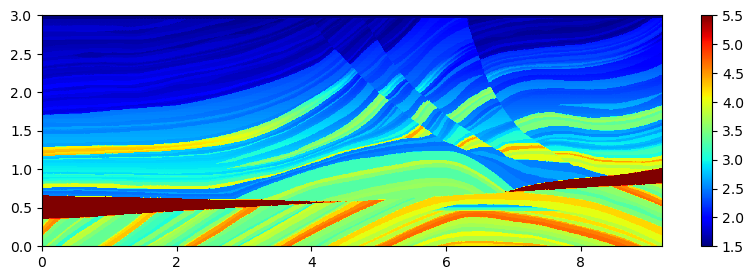

In [8]:
XGRID = np.linspace(XMIN, XMAX, 2301)
YGRID = np.linspace(YMIN, YMAX, 751)
XGRID, YGRID = np.meshgrid(XGRID, YGRID, indexing='ij')
plt.figure(figsize= (10, 3))
plt.colorbar(plt.pcolor(XGRID, YGRID, VELMODEL, cmap='jet'))
# plt.gca().invert_yaxis()
plt.show()

In [9]:
def interpolate_velocity_model(Xs, Ys, method='nearest'):
    crd = np.hstack([XGRID.reshape(-1,1), YGRID.reshape(-1,1)])
    Vs = griddata(crd, VELMODEL.flatten(), (Xs, Ys), method=method)
    return Vs.reshape(Xs.shape)

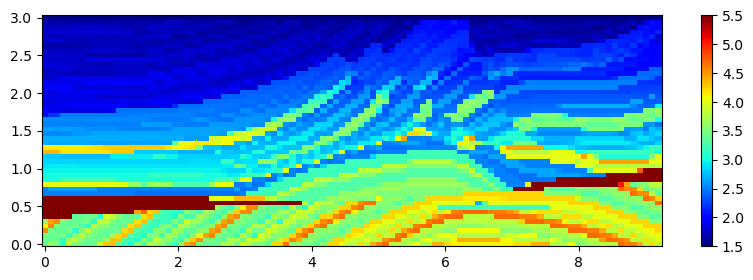

In [10]:
xt, yt = np.meshgrid(np.linspace(XMIN, XMAX, 100), np.linspace(YMIN, YMAX, 50), indexing='ij')
vt = interpolate_velocity_model(xt, yt, 'nearest')
plt.figure(figsize= (10, 3))
plt.colorbar(plt.pcolor(xt, yt, vt, cmap='jet'))
# plt.gca().invert_yaxis()
plt.show()

# Testing different velocity models 

In [11]:
import skfmm
from scipy.interpolate import griddata

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), (yd[1]-yd[0])/(Ny)
        sx, sy = np.round((source[0] - xd[0])/dx).astype(int), np.round((source[1] - yd[0])/dy).astype(int)
        phi = np.ones_like(vel)
        phi[sx, sy] = -1
        self.nx = (Nx+1, Ny+1)
        self.xg = np.meshgrid(np.linspace(xd[0], xd[1], Nx+1), np.linspace(yd[0], yd[1], Ny+1), indexing='ij')
        self.dx = (dx, dy)
        self.vg = vel
        self.Tg = skfmm.travel_time(phi,vel,dx=(dx, dy),order=2)
        
    def __call__(self, xs=0., ys=0.):
        crd = np.hstack([self.xg[0].reshape(-1,1), self.xg[1].reshape(-1,1)])
        ts = griddata(crd, self.Tg.flatten(), (xs, ys), method='nearest')
        return ts.reshape(xs.shape)
    
    @property
    def grid(self):
        return self.Tg
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.Tg)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

source =   1.6173563856851194 2.1661918463489


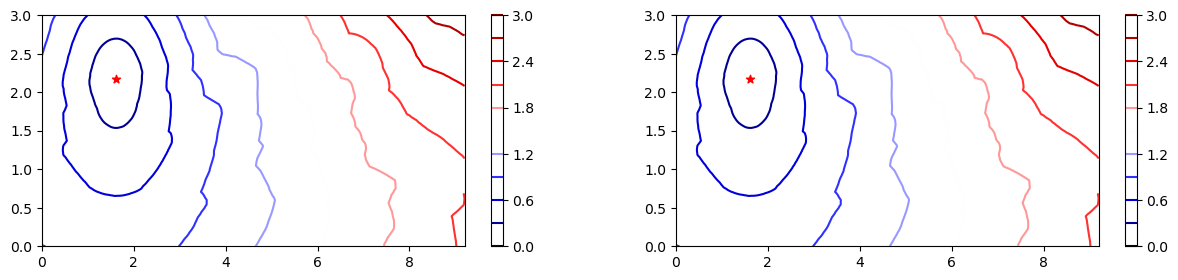

source =   5.921606062108163 2.887317037114091


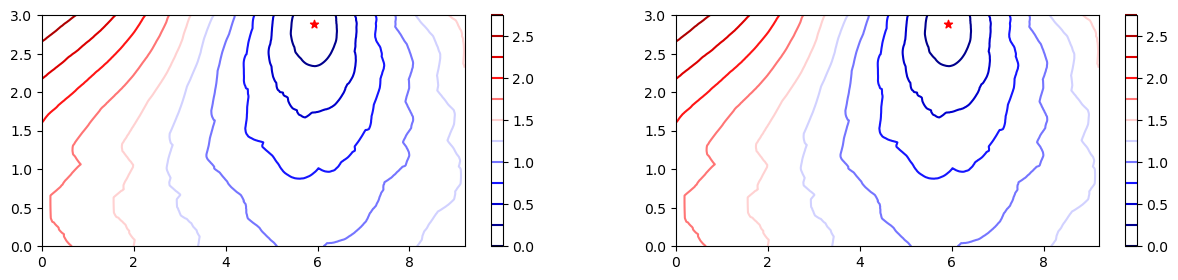

source =   3.363503704977644 0.7564313763071561


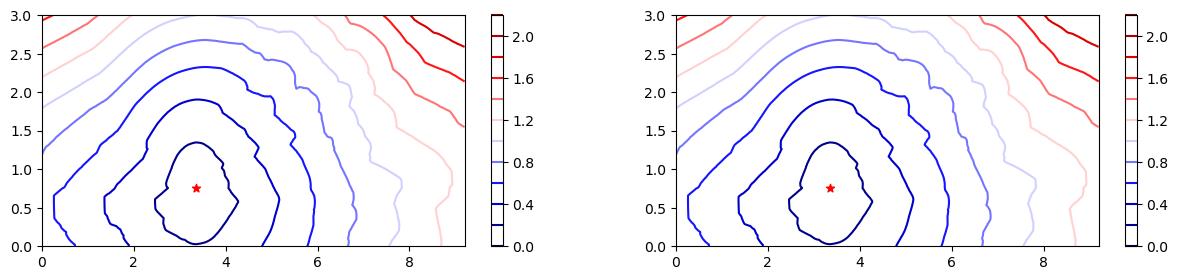

In [13]:

for i in range(3):
    xs = np.random.uniform(XMIN, XMAX)
    ys = np.random.uniform(YMIN, YMAX)
    print("source =  ", xs, ys)
    eik = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source = [xs, ys])
    t = eik.grid
    gt = eik.grad
    res = abs(gt[0]**2 + gt[1]**2 - 1/VELMODEL**2)
    
    Nx, Ny = 300, 100
    xp, yp = np.meshgrid(np.linspace(XMIN,XMAX,Nx), np.linspace(YMIN,YMAX,Ny), indexing='ij')
    tp = eik(xp, yp)

    fig, ax = plt.subplots(1,2,figsize=(15,3))
    # plt.colorbar(
    #     ax[0].pcolor(XGRID, YGRID, VELMODEL, cmap='seismic'), ax=ax[0]
    # )
    plt.colorbar(
        ax[0].contour(XGRID, YGRID, t, 10, cmap='seismic'), ax=ax[0]
    )
    plt.colorbar(
        ax[1].contour(XGRID, YGRID, t, 10, cmap='seismic'), ax=ax[1]
    )
    # plt.colorbar(
    #     ax[2].pcolor(xgrid, ygrid, res, cmap='seismic'), ax=ax[2]
    # )
    for j in range(len(ax)):
        ax[j].scatter(xs, ys, marker='*', color='r')
    plt.show()

In [14]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [15]:
SENSOR_SIZE = 20

In [16]:
sn.reset_session()
sn.set_random_seed(1234)

# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       embedding_size=20,
                       trunk_layers=2*[50],
                       branch_layers=2*[50],
                       root_layers=7*[20],
                       actf='tanh'):
        
        # recevier (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, actf)
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.root_inputs = [self.trunk * self.branch,
                            self.trunk + self.branch,
                            self.trunk - self.branch]
        
        self.output = sn.Functional('u', self.root_inputs, root_layers, actf)
        
        du_dx = sn.diff(self.output, self.trunk_inputs[0])
        du_dy = sn.diff(self.output, self.trunk_inputs[1])
        eikonal = sn.rename(du_dx**2 + du_dy**2, 'eikonal')
        data = sn.rename(self.output*1.0, 'data')
        
        #lipschitz reg
        du_dvbranch = sn.diff(self.output, self.branch_inputs[0])
        
        self.losses = [data] #, du_dvbranch, du_dtbranch]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=4e-4,
                             final_learning_rate=1e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        learning_rate = ([0,       500, 1500, 2000,    3000,   5000, 10000], 
                         [0.5e-4, 1e-4, 1e-4, 2e-4, 0.75e-4, 0.5e-4,  1e-5])
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": os.path.join(PATH_NAME, "weights"), "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()
        
    def plot_lbfgs_loss(self):
        loss = self.history_bfgs.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [17]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        self._sensor = [np.linspace(XMIN, XMAX, sensor_size+2)[1:-1],  np.full(sensor_size, YMAX)]
        self._shuffle = shuffle
        self._epoch = 1
        self._time0 = time.time()
        self._time = time.time()
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        epoch_time = time.time() - self._time
        total_time = time.time() - self._time0
        self._time = time.time()
        if self._epoch % 10 == 0:
            print(f"{self._epoch} - epoch-time: {epoch_time:.3f}s - total-time: {total_time:.3f}s ")
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._sample_size, self._batch_size
        inputs, targets, sample_weights = [], [], []
        for i in range(num_sample):
            delx, dely = XMAX-XMIN, YMAX-YMIN
            x_source = np.random.uniform(XMIN + 0.1*delx, XMAX - 0.1*delx)
            y_source = np.random.uniform(YMIN + 0.1*dely, YMAX - 0.1*dely)
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(x_source, y_source, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
            if (i+1) % 10 == 0:
                print(f"sample {i+1} is generated")
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)

    def __generate_batch_data(self, x_source, y_source, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        x_grid, y_grid = XGRID, YGRID
        eik2d = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source=[x_source, y_source])
        
        # sample data
        ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(batch_size['data']) + counter
        counter += ids_data.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        t_sensor = eik2d(x_sensor, y_sensor)
        t_branch = np.tile(t_sensor, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Nx=500, Ny=200, sensor_size=10):
        counter = 0
        
        # eikonal solution
        eik2d = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source=[Xs, Ys])
        
        x_grid, y_grid = np.meshgrid(np.linspace(XMIN,XMAX,Nx), np.linspace(YMIN,YMAX,Ny), indexing='ij')
        t_grid = eik2d(x_grid, y_grid)
        
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        t_sensor = eik2d(x_sensor, y_sensor)
        t_branch = np.tile(t_sensor, (size_sample, 1))
        
        # inputs
        inputs = [x_trunk, y_trunk, t_branch]
        
        return inputs, t_sensor, target
    
    

In [18]:
dg = DataGenerator(
    sample_size=200,
    batch_size={'data': 10000, 'domain': 1000, 'bc':50},
    sensor_size=SENSOR_SIZE
)

sample 10 is generated
sample 20 is generated
sample 30 is generated
sample 40 is generated
sample 50 is generated
sample 60 is generated
sample 70 is generated
sample 80 is generated
sample 90 is generated
sample 100 is generated
sample 110 is generated
sample 120 is generated
sample 130 is generated
sample 140 is generated
sample 150 is generated
sample 160 is generated
sample 170 is generated
sample 180 is generated
sample 190 is generated
sample 200 is generated


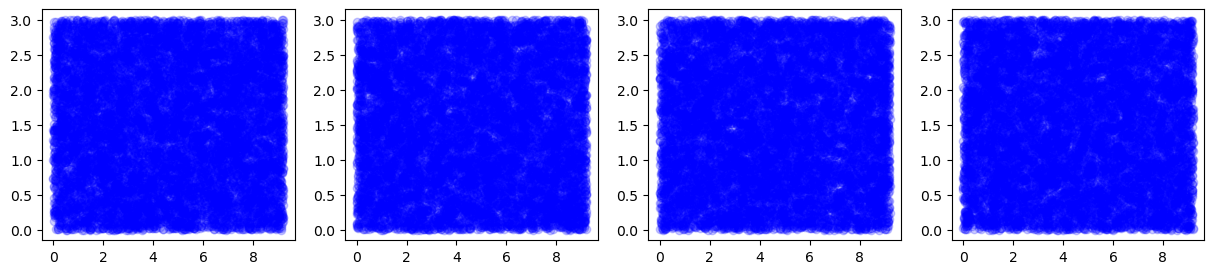

In [19]:
from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, t_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [20]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=100,
    branch_layers=[50],
    trunk_layers=[20, 50, 100],
    root_layers=[100, 80, 60, 40, 20],
    actf='tanh'
)

In [21]:
DON.train(dg, epochs=5000, verbose=0)
# [x.shape for x in dg[0][0]]

2022-10-22 22:37:20.515369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:37:20.516084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:37:20.516639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:37:20.517545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 22:37:20.518169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

10 - epoch-time: 1.106s - total-time: 293.141s 
20 - epoch-time: 1.114s - total-time: 304.224s 
30 - epoch-time: 1.115s - total-time: 315.357s 
40 - epoch-time: 1.112s - total-time: 326.464s 
50 - epoch-time: 1.108s - total-time: 337.586s 
60 - epoch-time: 1.105s - total-time: 348.696s 
70 - epoch-time: 1.113s - total-time: 359.788s 
80 - epoch-time: 1.105s - total-time: 370.883s 
90 - epoch-time: 1.111s - total-time: 381.981s 
100 - epoch-time: 1.107s - total-time: 393.092s 
110 - epoch-time: 1.105s - total-time: 404.185s 
120 - epoch-time: 1.125s - total-time: 415.297s 
130 - epoch-time: 1.111s - total-time: 426.415s 
140 - epoch-time: 1.119s - total-time: 437.532s 
150 - epoch-time: 1.108s - total-time: 448.664s 
160 - epoch-time: 1.116s - total-time: 459.823s 
170 - epoch-time: 1.100s - total-time: 470.932s 
180 - epoch-time: 1.116s - total-time: 482.032s 
190 - epoch-time: 1.107s - total-time: 493.146s 
200 - epoch-time: 1.126s - total-time: 504.300s 
210 - epoch-time: 1.123s - to

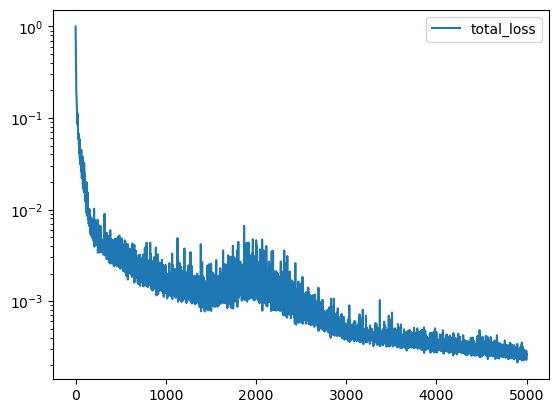

In [22]:
DON.plot_loss()

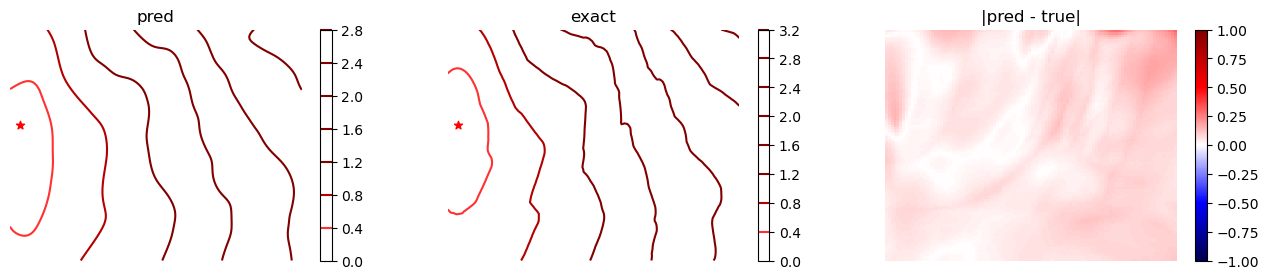

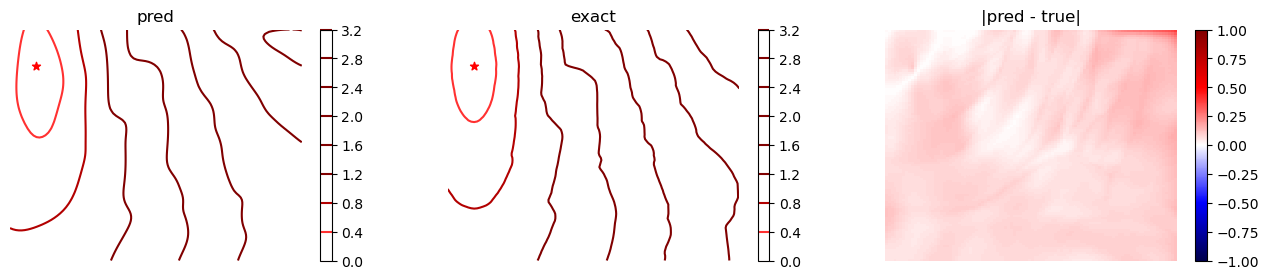

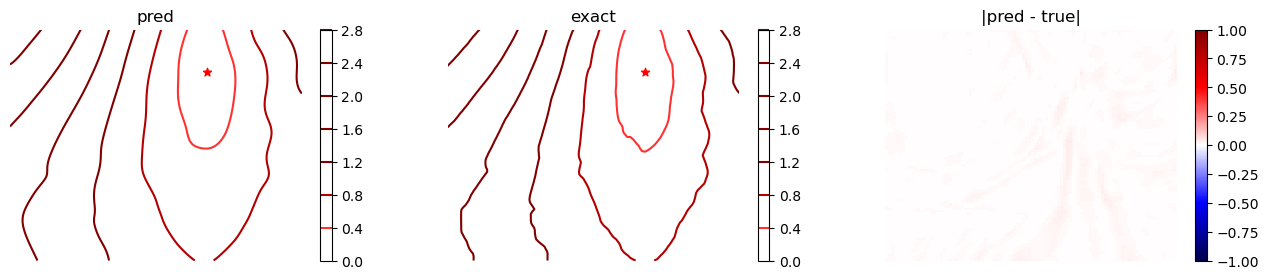

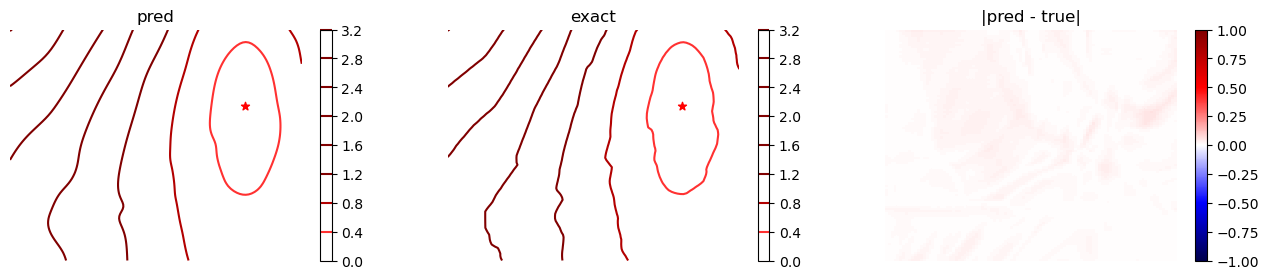

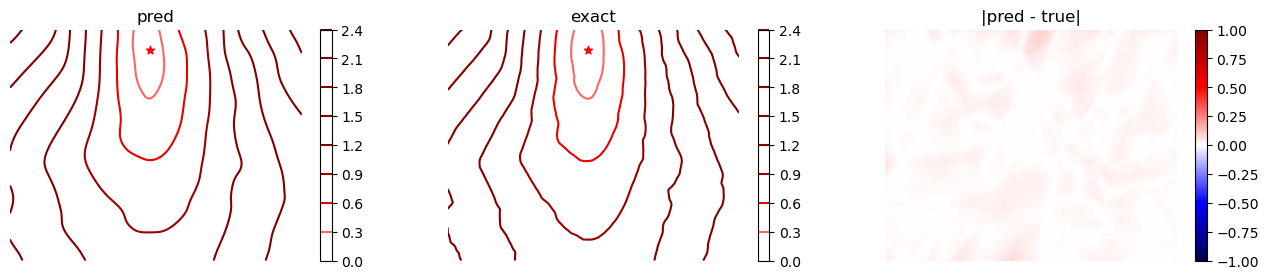

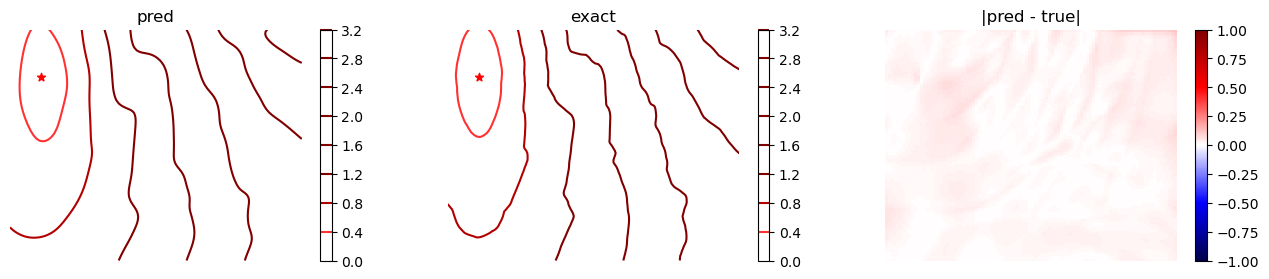

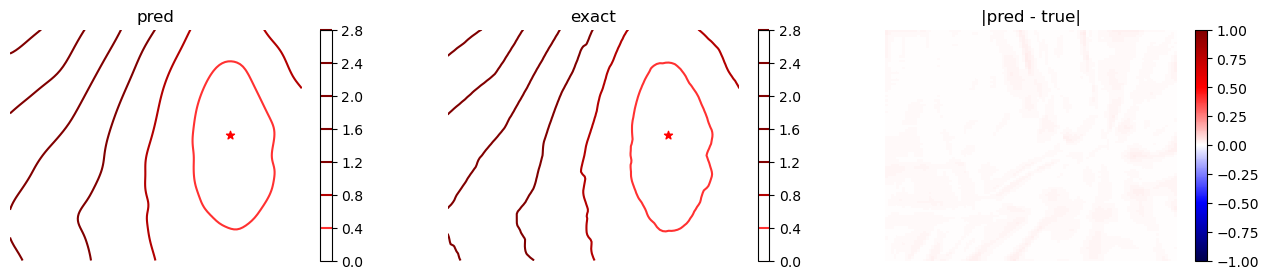

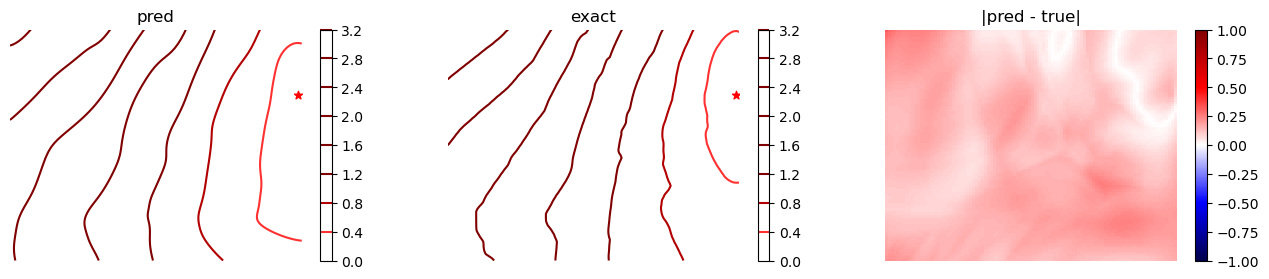

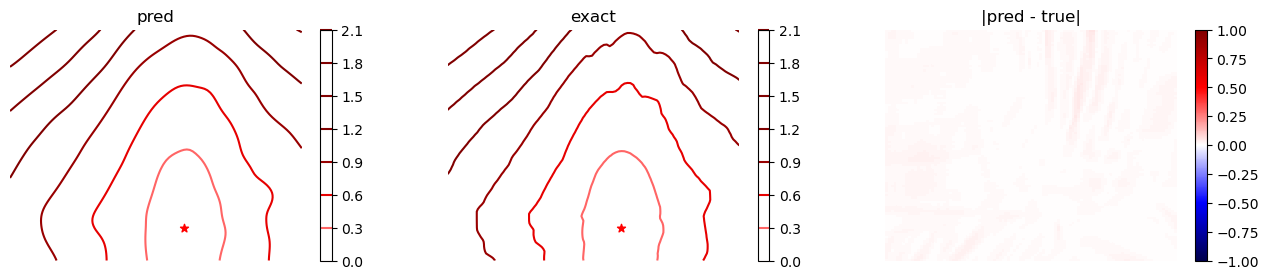

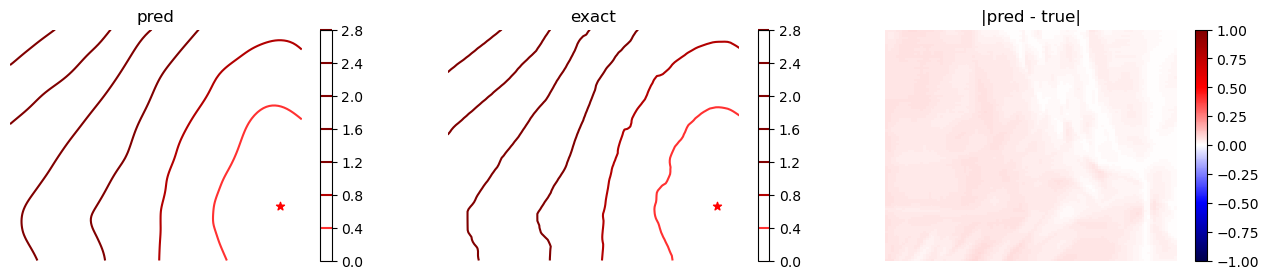

In [23]:
np.random.seed(1234)
Nx, Ny = 100, 100

for i in range(10):
    x_source = np.random.uniform(XMIN, XMAX)
    y_source = np.random.uniform(YMIN, YMAX) 
    
    test_data, sensor_input, target_data = dg.generate_test_data(x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 3, figsize=(16, 3))
    
    # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    # ax[0].set_title('velocity field')
    # ax[0].axis('off')
    # plt.colorbar(ax0, ax=ax[0])
    ax = [None, ax[0], ax[1], ax[2]]
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[1].scatter(x_source, y_source, marker='*', color='r')
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[2].scatter(x_source, y_source, marker='*', color='r')
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()

In [24]:
DON.train_lbfgs(dg, epochs=1000, verbose=0)

5000 - epoch-time: 28.214s - total-time: 5920.434s 
5010 - epoch-time: 1.110s - total-time: 5933.034s 
5020 - epoch-time: 1.119s - total-time: 5944.244s 
5030 - epoch-time: 1.140s - total-time: 5955.527s 
5040 - epoch-time: 1.140s - total-time: 5966.942s 
5050 - epoch-time: 1.116s - total-time: 5978.412s 
5060 - epoch-time: 1.150s - total-time: 5989.951s 
5070 - epoch-time: 1.165s - total-time: 6001.534s 
5080 - epoch-time: 1.159s - total-time: 6013.091s 
5090 - epoch-time: 1.153s - total-time: 6024.634s 
5100 - epoch-time: 1.166s - total-time: 6036.178s 
5110 - epoch-time: 1.163s - total-time: 6047.728s 
5120 - epoch-time: 1.170s - total-time: 6059.304s 
5130 - epoch-time: 1.144s - total-time: 6070.883s 
5140 - epoch-time: 1.125s - total-time: 6082.325s 
5150 - epoch-time: 1.150s - total-time: 6093.879s 
5160 - epoch-time: 1.134s - total-time: 6105.405s 
5170 - epoch-time: 1.151s - total-time: 6116.952s 
5180 - epoch-time: 1.157s - total-time: 6128.511s 
5190 - epoch-time: 1.163s - to

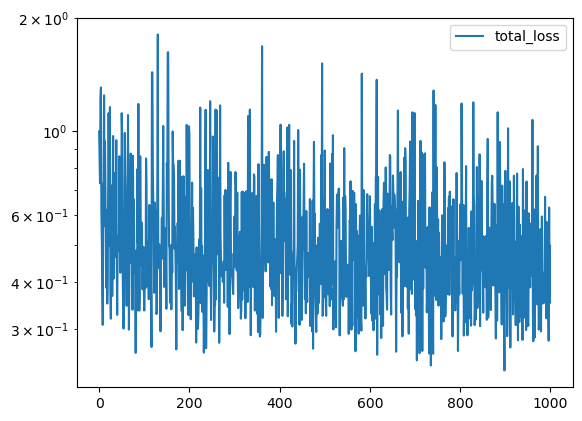

In [25]:
DON.plot_lbfgs_loss()

In [26]:
DON.model.save_weights(os.path.join(PATH_NAME, "weights-lbfgs.hdf5"))

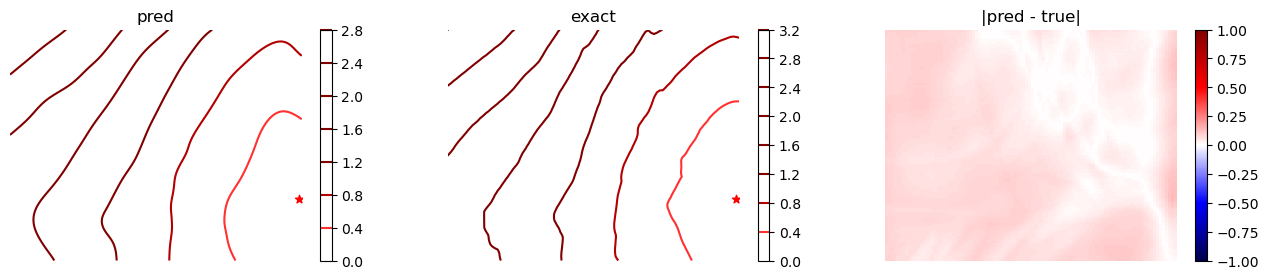

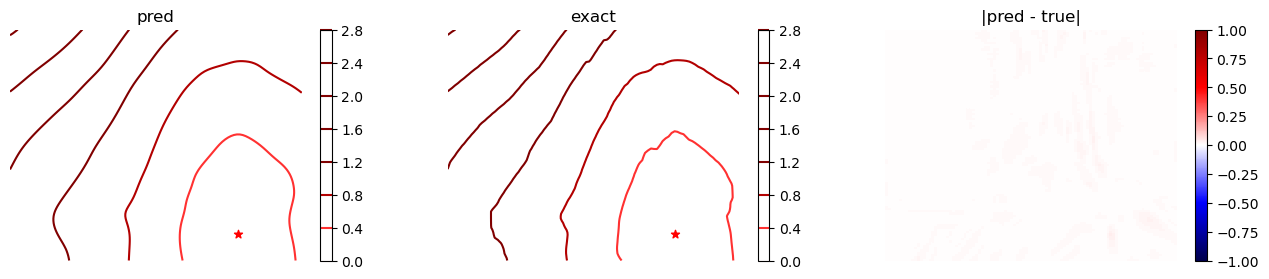

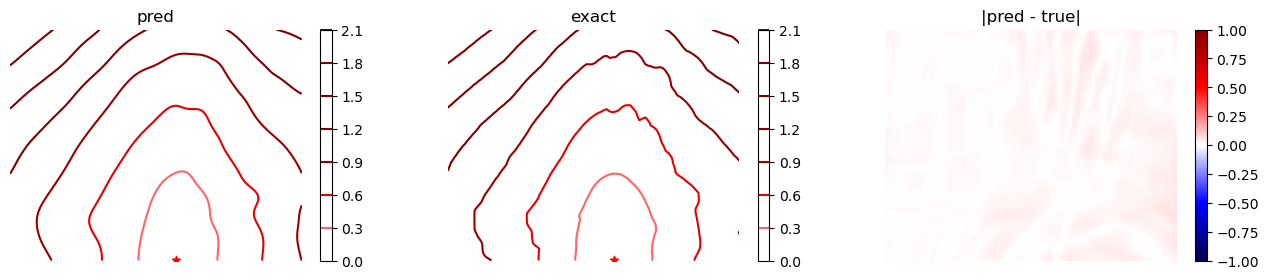

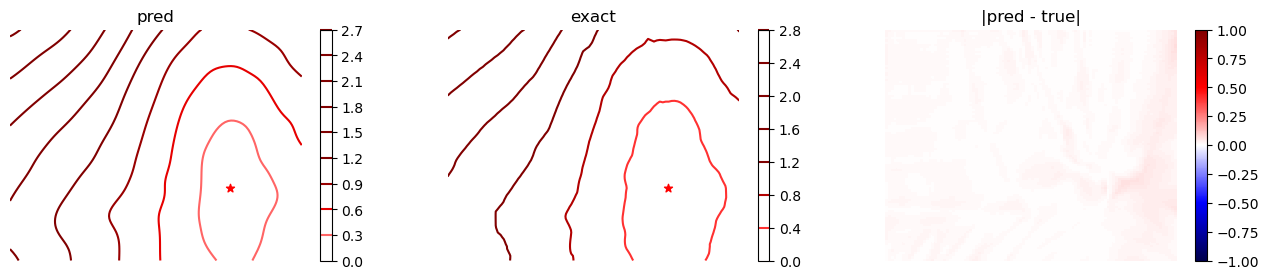

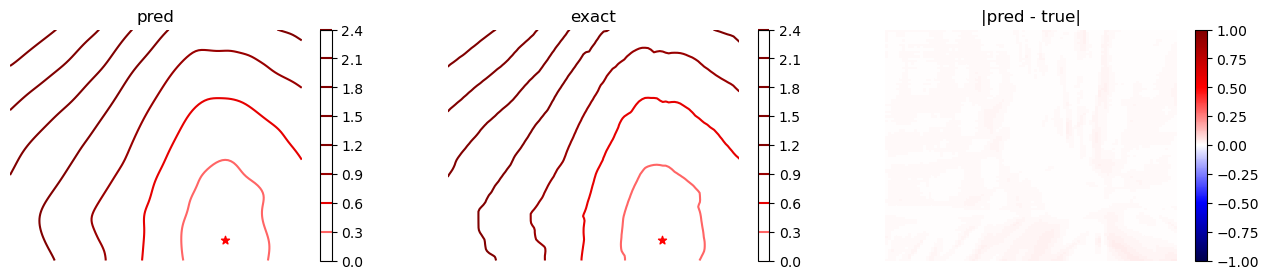

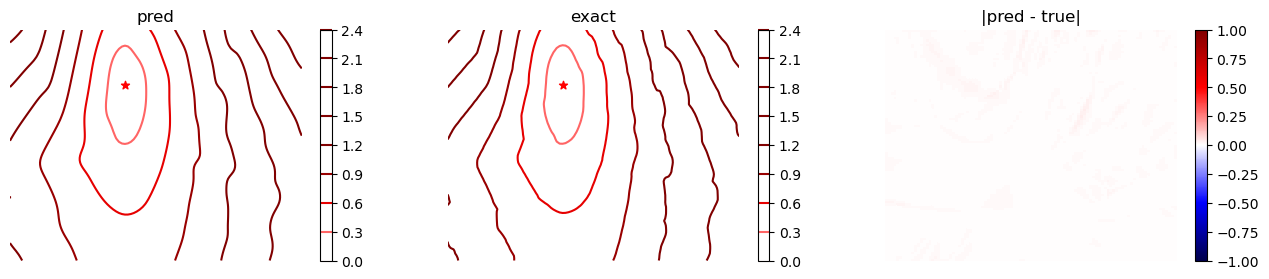

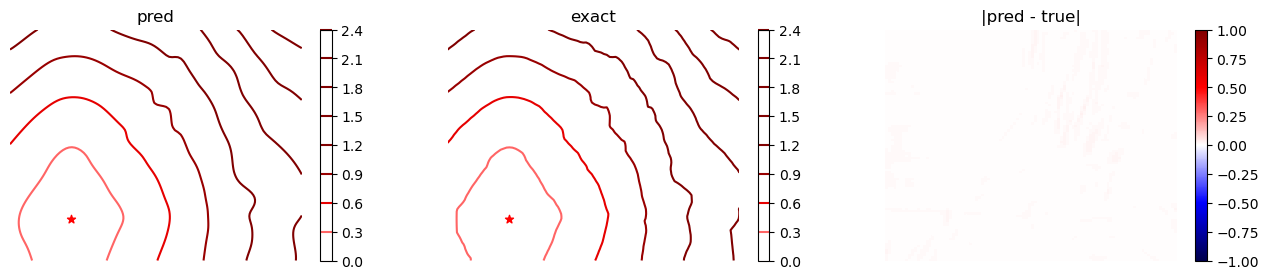

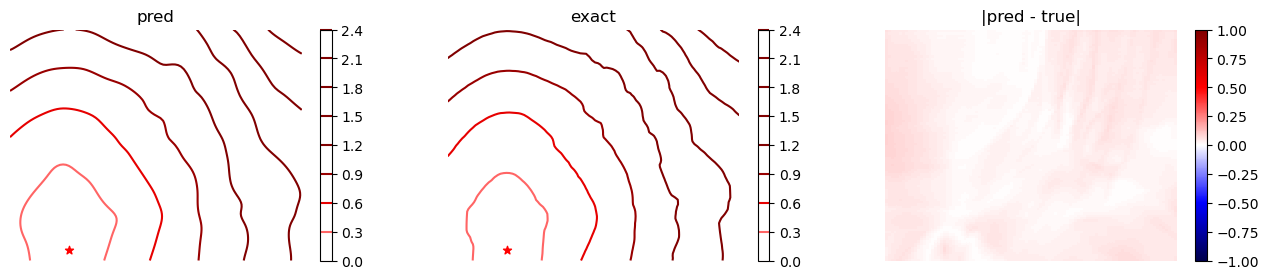

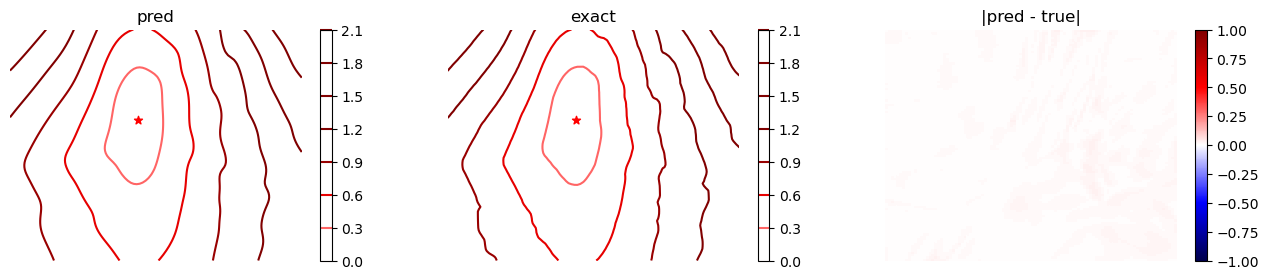

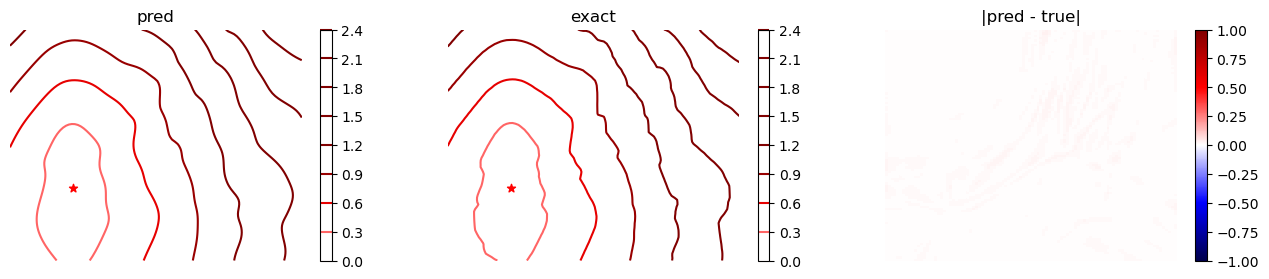

In [27]:
Nx, Ny = 100, 100

for i in range(10):
    x_source = np.random.uniform(XMIN, XMAX)
    y_source = np.random.uniform(YMIN, YMAX) 
    
    test_data, sensor_input, target_data = dg.generate_test_data(x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 3, figsize=(16, 3))
    
    # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    # ax[0].set_title('velocity field')
    # ax[0].axis('off')
    # plt.colorbar(ax0, ax=ax[0])
    ax = [None, ax[0], ax[1], ax[2]]
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[1].scatter(x_source, y_source, marker='*', color='r')
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[2].scatter(x_source, y_source, marker='*', color='r')
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()